## Loading Libraries

In [1]:
import os
import copy
import time
from tqdm import tqdm
from datetime import datetime
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

In [2]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from torchvision.io import read_image
torch.manual_seed(0)

## Data Loading

In [3]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        labels = []
        paths = []
        for file_name in os.listdir(img_dir):
            labels.append(int(file_name.split('_')[0]))
            paths.append(os.path.join(img_dir, file_name))
        
        self.img_labels = pd.DataFrame([paths, labels]).T
        del labels
        del paths

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label   

In [4]:
class AugmentedDataset(Dataset):
    def __init__(self, dataset, weights=None):
        self.dataset = dataset
        self.weights = np.array(weights)
        self.transform = dataset.transform
        self.target_transform = dataset.target_transform
        self.num_classes = len(self.dataset.img_labels[1].unique())
        
        if weights is None:
            self.weights = np.ones(self.num_classes, dtype=np.int8)
        if len(self.weights) != self.num_classes:
            raise ValueError("Expected {} weights. Provided {}. len(weights) should be equal to number of classes".
                             format(self.num_classes, len(self.weights)))

        labels = []
        paths = []
        df = self.dataset.img_labels
        for fpath, label in df.itertuples(index=False):
            for _ in range(self.weights[label]):
                paths.append(fpath)
                labels.append(label)
        
        self.img_labels = pd.DataFrame([paths, labels]).T

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [5]:
weights = models.MobileNet_V3_Large_Weights.IMAGENET1K_V2

# We are converting into RGB format as MobileNet expects 3 channel images.
data_transforms = {"train" : transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(degrees=20),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        weights.transforms()
    ]),
    "val" : transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        weights.transforms()
    ])
}

In [6]:
train_path = "train"
val_path = "val"

train_imgDataset = ImageDataset(img_dir=train_path, transform=data_transforms["train"])
valid_imgDataset = ImageDataset(img_dir=val_path, transform=data_transforms["val"])

In [7]:
train_imgDataset.img_labels[1].value_counts(sort=False)

1
0     200
1     313
2     669
3      70
4     675
5    3022
6      87
Name: count, dtype: int64

In [8]:
valid_imgDataset.img_labels[1].value_counts(sort=False)

1
0     127
1     201
2     430
3      45
4     438
5    2000
6      55
Name: count, dtype: int64

In [9]:
print(len(train_imgDataset), len(valid_imgDataset))

5036 3296


In [10]:
label_weights = [3,3,2,5,2,1,4]
train_dataset = AugmentedDataset(train_imgDataset, weights=label_weights)
valid_dataset = AugmentedDataset(valid_imgDataset)

In [11]:
print(len(train_dataset), len(valid_dataset))

7947 3296


In [12]:
train_dataset.img_labels[1].value_counts(sort=False)

1
0     600
1     939
2    1338
3     350
4    1350
5    3022
6     348
Name: count, dtype: int64

In [13]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)
len(train_loader)

125

In [14]:
def imshow_(inp, title=None):
    inp = inp.permute(1, 2, 0).numpy()       # Permutes the dimensions of the image.
    inp = (inp - inp.min()) / (inp.max() - inp.min())
    print(inp.shape)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    # plt.pause(0.1)
    plt.show()

(224, 224, 3)


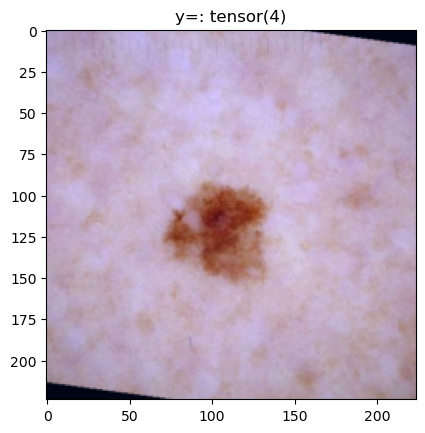

(224, 224, 3)


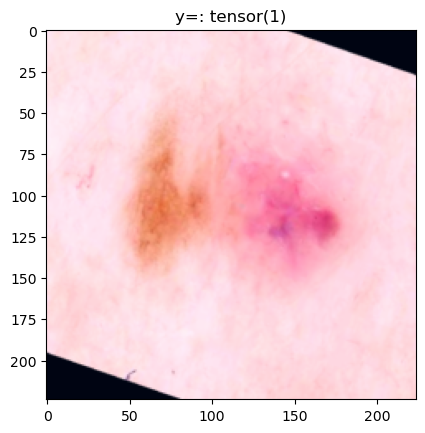

(224, 224, 3)


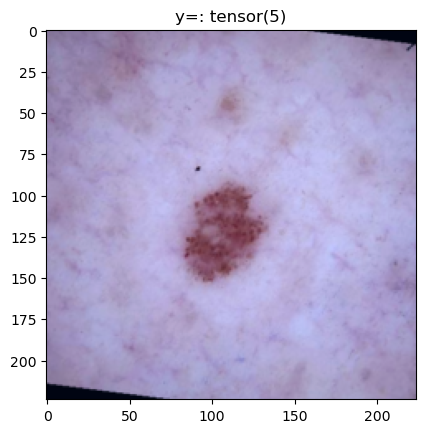

In [15]:
for x,y  in train_loader:
    for i in range(len(y)):
        imshow_(x[i],"y=: {}".format(str(y[i])))
        if i==2:
            break
    break

## Training Model 1

### Hyperparameters

In [16]:
n_epochs = 12
batch_size = 64
lr = 0.0005
n_classes = 7
momentum = 0.9

In [17]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)

In [18]:
model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The device type is:", device)

The device type is: cpu


In [20]:
for param in model.parameters():
    param.requires_grad = False

In [21]:
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [22]:
model.features[16] = models.mobilenetv3.Conv2dNormActivation(
    in_channels = 160,
    out_channels = 800,
    kernel_size = 1,
    stride = 1,
    bias = False,
    # norm_layer = functools.partial(nn.BatchNorm2d, eps=0.001, momentum=0.01),
    activation_layer=lambda *args, **kwargs: nn.Hardswish()
)

model.classifier = nn.Sequential(
    nn.Linear(in_features=800, out_features=1024, bias=True),
    nn.Hardswish(),
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1024, out_features=n_classes, bias=True)
)

In [23]:
model = model.to(device)

In [24]:
class_weights = torch.Tensor(1/train_dataset.img_labels[1].value_counts(sort=False, normalize=True))
class_weights/class_weights.min()

tensor([5.0367, 3.2183, 2.2586, 8.6343, 2.2385, 1.0000, 8.6839])

In [25]:
class_weights = torch.Tensor([3, 2.5, 2, 5, 2, 1, 5])
class_weights = class_weights.to(device)
print(class_weights)

tensor([3.0000, 2.5000, 2.0000, 5.0000, 2.0000, 1.0000, 5.0000])


### Training only last 2 layers

In [26]:
criterion1 = nn.CrossEntropyLoss(weight=class_weights)
"""
optimizer1 = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))
optimizer1 = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
scheduler1 = lr_scheduler.StepLR(optimizer1, step_size=3, gamma=0.5)
scheduler1 = lr_scheduler.CyclicLR(optimizer1, base_lr=0.1, max_lr=0.3,step_size_up=5,mode="triangular2")
scheduler1 = lr_scheduler.ReduceLROnPlateau(optimizer1, mode='max', factor=0.5, patience=2)
"""
optimizer1 = torch.optim.Adam(model.parameters(), lr=lr)
scheduler1 = lr_scheduler.StepLR(optimizer1, step_size=3, gamma=0.5)

In [27]:
def train_model(model, train_loader,validation_loader, criterion, optimizer, n_epochs, scheduler=None, print_=True):
    loss_list = []
    accuracy_list = []
    models_list = []
    correct = 0
    n_test = len(validation_loader.dataset)
    accuracy_best=0
    train_cost_best = 2
    best_model_wts = copy.deepcopy(model.state_dict())

    # Loop through epochs
    for epoch in range(n_epochs):
        loss_sublist = []
        model.train()
        
        if print_:
            print(f"Learning rate for epoch {epoch+1}:", optimizer.param_groups[0]['lr'])
            
        # Loop through the data in loader
        for x, y in tqdm(train_loader):
            x, y=x.to(device), y.to(device)
            z = model(x)
            loss = criterion(z, y)
            loss_sublist.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_cost = np.mean(loss_sublist)
        loss_list.append(train_cost)
        
        correct = 0
        model.eval()
        print("Fetching validation results for epoch {} ...".format(epoch+1))

        with torch.no_grad():
            for x_test, y_test in validation_loader:
                x_test, y_test=x_test.to(device), y_test.to(device)
                z = model(x_test)
                _, yhat = torch.max(z.data, 1)
                correct += (yhat == y_test).sum().item()
            accuracy = correct / n_test
            accuracy_list.append(accuracy)
        
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(accuracy)
            else:
                scheduler.step()
        
        if accuracy>accuracy_best:
            accuracy_best = accuracy
            train_cost_best = train_cost
            best_model_wts = copy.deepcopy(model.state_dict())
        elif accuracy == accuracy_best and train_cost < train_cost_best:
            train_cost_best = train_cost
            best_model_wts = copy.deepcopy(model.state_dict())
      
        if print_:
            print("The training cost for epoch " + str(epoch + 1) + ": " + str(train_cost))
            print("The validation accuracy for epoch " + str(epoch + 1) + ": " + str(accuracy))
            print()
        models_list.append(copy.deepcopy(model.state_dict()))
    model.load_state_dict(best_model_wts)
    return accuracy_list, loss_list, model, models_list

In [28]:
start_datetime = datetime.now()
start_time=time.time()
print("Training started at:", datetime.now())

accuracy_list,loss_list, model, mod_list = train_model(model,train_loader , valid_loader, criterion1, optimizer1, scheduler=scheduler1, n_epochs=n_epochs)

end_datetime = datetime.now()
current_time = time.time()
elapsed_time = current_time - start_time
print("Elapsed time", elapsed_time )

Training started at: 2025-06-01 11:19:33.035852
Learning rate for epoch 1: 0.0005


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [04:38<00:00,  2.23s/it]


Fetching validation results for epoch 1 ...
The training cost for epoch 1: 1.1898593125343322
The validation accuracy for epoch 1: 0.6926577669902912

Learning rate for epoch 2: 0.0005


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [03:50<00:00,  1.85s/it]


Fetching validation results for epoch 2 ...
The training cost for epoch 2: 0.9014816164970398
The validation accuracy for epoch 2: 0.7023665048543689

Learning rate for epoch 3: 0.0005


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [03:53<00:00,  1.87s/it]


Fetching validation results for epoch 3 ...
The training cost for epoch 3: 0.8359958701133728
The validation accuracy for epoch 3: 0.7057038834951457

Learning rate for epoch 4: 0.00025


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [03:47<00:00,  1.82s/it]


Fetching validation results for epoch 4 ...
The training cost for epoch 4: 0.7644465589523315
The validation accuracy for epoch 4: 0.7223907766990292

Learning rate for epoch 5: 0.00025


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [04:04<00:00,  1.96s/it]


Fetching validation results for epoch 5 ...
The training cost for epoch 5: 0.7429976646900177
The validation accuracy for epoch 5: 0.7236043689320388

Learning rate for epoch 6: 0.00025


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [04:09<00:00,  2.00s/it]


Fetching validation results for epoch 6 ...
The training cost for epoch 6: 0.7309866826534271
The validation accuracy for epoch 6: 0.714502427184466

Learning rate for epoch 7: 0.000125


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [03:47<00:00,  1.82s/it]


Fetching validation results for epoch 7 ...
The training cost for epoch 7: 0.707380909204483
The validation accuracy for epoch 7: 0.722997572815534

Learning rate for epoch 8: 0.000125


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [03:48<00:00,  1.83s/it]


Fetching validation results for epoch 8 ...
The training cost for epoch 8: 0.6887303223609924
The validation accuracy for epoch 8: 0.7154126213592233

Learning rate for epoch 9: 0.000125


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [03:49<00:00,  1.84s/it]


Fetching validation results for epoch 9 ...
The training cost for epoch 9: 0.6753647046089173
The validation accuracy for epoch 9: 0.6996359223300971

Learning rate for epoch 10: 6.25e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [03:51<00:00,  1.85s/it]


Fetching validation results for epoch 10 ...
The training cost for epoch 10: 0.6771950860023499
The validation accuracy for epoch 10: 0.7214805825242718

Learning rate for epoch 11: 6.25e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [03:51<00:00,  1.85s/it]


Fetching validation results for epoch 11 ...
The training cost for epoch 11: 0.6622734608650207
The validation accuracy for epoch 11: 0.7163228155339806

Learning rate for epoch 12: 6.25e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [03:51<00:00,  1.85s/it]


Fetching validation results for epoch 12 ...
The training cost for epoch 12: 0.6580162920951843
The validation accuracy for epoch 12: 0.7157160194174758

Elapsed time 3499.574522972107


In [34]:
def evaluate(model, dataloader, class_names, title):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

    # Compute classification metrics
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    tot_acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
    f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)

    print("\nClassification Report:")
    print(f"Total accuracy: {tot_acc}\n")
    print(pd.DataFrame([class_accuracy, precision, recall, f1], columns=class_names, index=["Accuracy", "Precision", "Recall", "F1-Score"]).T)

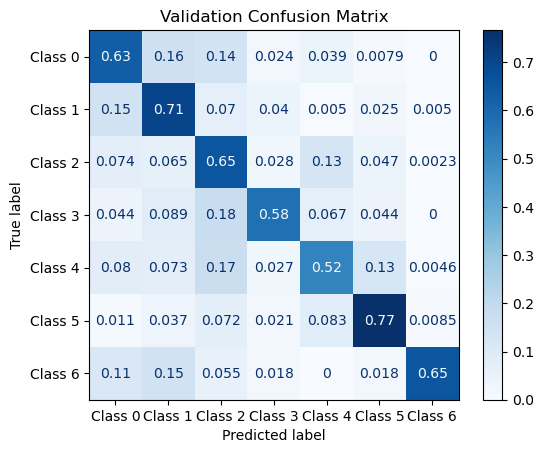


Classification Report:
Total accuracy: 0.7057038834951457

         Accuracy  Precision    Recall  F1-Score
Class 0  0.629921   0.384615  0.629921  0.477612
Class 1  0.706468   0.459547  0.706468  0.556863
Class 2  0.653488   0.517495  0.653488  0.577595
Class 3  0.577778   0.250000  0.577778  0.348993
Class 4  0.520548   0.497817  0.520548  0.508929
Class 5  0.766500   0.948052  0.766500  0.847664
Class 6  0.654545   0.631579  0.654545  0.642857


In [33]:
model.load_state_dict(mod_list[2])
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6"]
evaluate(model, valid_loader, class_names, title="Validation Confusion Matrix")

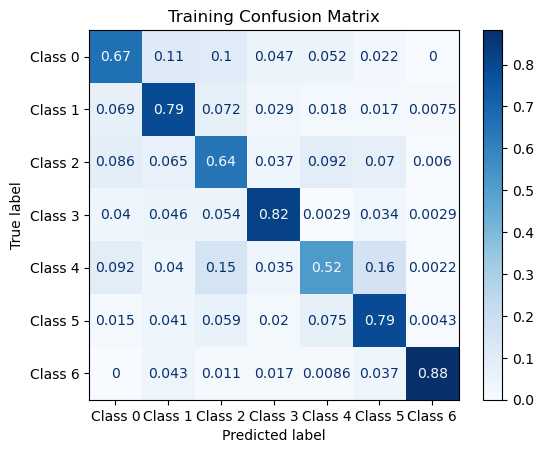


Classification Report:
Total accuracy: 0.7134767836919592

         Accuracy  Precision    Recall  F1-Score
Class 0  0.665000   0.523622  0.665000  0.585903
Class 1  0.787007   0.671818  0.787007  0.724865
Class 2  0.644245   0.614836  0.644245  0.629197
Class 3  0.820000   0.570577  0.820000  0.672919
Class 4  0.517037   0.635123  0.517037  0.570029
Class 5  0.786896   0.867250  0.786896  0.825121
Class 6  0.882184   0.905605  0.882184  0.893741


In [34]:
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6"]
evaluate(model, train_loader, class_names, title="Training Confusion Matrix")

In [35]:
torch.save(model.state_dict(), "modstage1/model_large_1_706.pt")

## Fine Tuning

In [41]:
model.load_state_dict(torch.load("modstage1/model_large_1_706.pt", weights_only = True))
for param in model.parameters():
    param.requires_grad = True

In [42]:
class_weights = torch.Tensor(1/train_dataset.img_labels[1].value_counts(sort=False, normalize=True))
class_weights/class_weights.min()

tensor([5.0367, 3.2183, 2.2586, 8.6343, 2.2385, 1.0000, 8.6839])

In [43]:
class_weights = torch.Tensor([3, 2.5, 2, 4, 2, 1, 4])
class_weights = class_weights.to(device)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=32, shuffle=False)

In [40]:
criterion2 = nn.CrossEntropyLoss(weight=class_weights)
optimizer2 = torch.optim.Adam(model.parameters(), lr=lr/2, weight_decay = 1e-3)
# optimizer2 = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
scheduler2 = lr_scheduler.StepLR(optimizer2, step_size=2, gamma=0.5)

start_datetime = datetime.now()
start_time=time.time()
print("Training started at:", datetime.now())

accuracy_list2,loss_list2, model, mod_list2 = train_model(model,train_loader , valid_loader, criterion2, optimizer2, scheduler=scheduler2, n_epochs=6)

end_datetime = datetime.now()
current_time = time.time()
elapsed_time = current_time - start_time
print("Elapsed time", elapsed_time )

Training started at: 2025-06-02 13:30:00.613778
Learning rate for epoch 1: 0.00025


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [08:22<00:00,  4.02s/it]


Fetching validation results for epoch 1 ...
The training cost for epoch 1: 0.626069385766983
The validation accuracy for epoch 1: 0.8021844660194175

Learning rate for epoch 2: 0.00025


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [08:36<00:00,  4.13s/it]


Fetching validation results for epoch 2 ...
The training cost for epoch 2: 0.37301017093658445
The validation accuracy for epoch 2: 0.7900485436893204

Learning rate for epoch 3: 0.000125


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [08:01<00:00,  3.86s/it]


Fetching validation results for epoch 3 ...
The training cost for epoch 3: 0.23272123539447784
The validation accuracy for epoch 3: 0.8322208737864077

Learning rate for epoch 4: 0.000125


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [08:02<00:00,  3.86s/it]


Fetching validation results for epoch 4 ...
The training cost for epoch 4: 0.1739003734588623
The validation accuracy for epoch 4: 0.8267597087378641

Learning rate for epoch 5: 6.25e-05


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [08:01<00:00,  3.85s/it]


Fetching validation results for epoch 5 ...
The training cost for epoch 5: 0.11387000885605812
The validation accuracy for epoch 5: 0.8398058252427184

Learning rate for epoch 6: 6.25e-05


100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [08:10<00:00,  3.92s/it]


Fetching validation results for epoch 6 ...
The training cost for epoch 6: 0.10468164968490601
The validation accuracy for epoch 6: 0.8340412621359223

Elapsed time 3277.358987569809


In [44]:
model.load_state_dict(mod_list2[-2])

<All keys matched successfully>

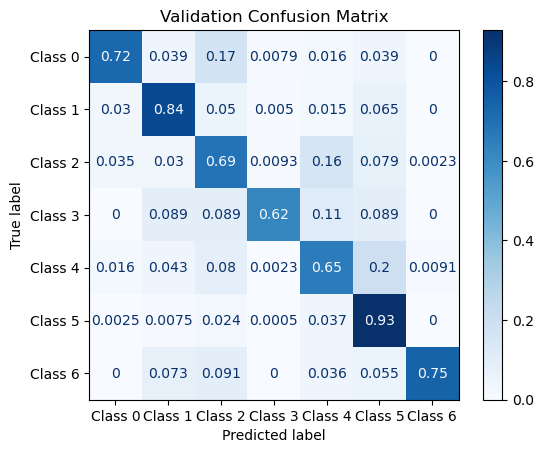


Classification Report:
Total accuracy: 0.8398058252427184

         Accuracy  Precision    Recall  F1-Score
Class 0  0.724409   0.736000  0.724409  0.730159
Class 1  0.835821   0.736842  0.835821  0.783217
Class 2  0.688372   0.704762  0.688372  0.696471
Class 3  0.622222   0.777778  0.622222  0.691358
Class 4  0.652968   0.651481  0.652968  0.652223
Class 5  0.928500   0.927572  0.928500  0.928036
Class 6  0.745455   0.891304  0.745455  0.811881


In [46]:
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6"]
evaluate(model, valid_loader, class_names, title="Validation Confusion Matrix")

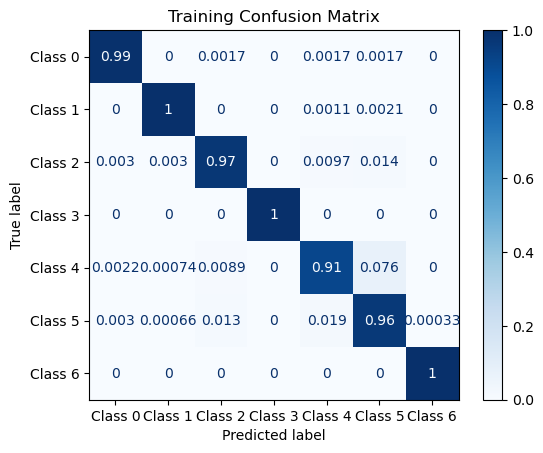


Classification Report:
Total accuracy: 0.9656474141185353

         Accuracy  Precision    Recall  F1-Score
Class 0  0.995000   0.973899  0.995000  0.984336
Class 1  0.996805   0.992577  0.996805  0.994687
Class 2  0.970105   0.961481  0.970105  0.965774
Class 3  1.000000   1.000000  1.000000  1.000000
Class 4  0.912593   0.944061  0.912593  0.928060
Class 5  0.963931   0.959170  0.963931  0.961545
Class 6  1.000000   0.997135  1.000000  0.998565


In [47]:
class_names = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6"]
evaluate(model, train_loader, class_names, title="Training Confusion Matrix")

In [59]:
torch.save(model.state_dict(), "modstage1/model_large_2_840.pt")

Best Model: modstage1/model_large_2_840.pt (All Classes above 60%) Train:96.5, Valid:84.0
- modstage1/model_large_2_839.pt (All Classes above 60%) Train:97.3, Valid:83.9
- modstage1/model_large_2_832.pt (All Classes above 60%) Train:97.3, Valid:83.2